# London to Birmingham Train Simulation
Name: Ciaran Egan


In [9]:
import numpy as np
import math
import random
import simpy
import pandas as pd
import scipy.stats as stats
import string
import pandasql as ps
import plotly.graph_objects as go
import plotly
import matplotlib as mpl
import matplotlib.pyplot as plt

random.seed(198666)

## 1. Physics Calculations:

A couple of formatting notes:
- Time is always expressed as a proportion of hours
- Distance is expressed as a proportion of KM

### 1.1 The location of the signalling blocks

Assume at equal intervals along the large straight between London and Birmingham 

In [10]:
def Block_Location(k):
    Bl_Loc = np.linspace(0, 145, k + 1)
    return (Bl_Loc)

### 1.2 The Top Speed Calculations

Get the time spent at top speed given a fixed distance

In [11]:
def TS_time(TS_Dist):  # The time spent at top speed
    Time = TS_Dist / 300
    return (Time)

### 1.3 Decceleration
Some Info about the decceleration, given an input distance

In [12]:
def Dec_Time_Exit_Speed(Dec_Dist):  # The Exit Speed
    Out_Dict = {}
    Out_Dict['Exit_Speed'] = math.sqrt(max(300 ** 2 - 2 * 4665.6 * Dec_Dist, 0))
    Out_Dict['Time'] = 2 * Dec_Dist / (300 + Out_Dict['Exit_Speed'])
    return (Out_Dict)

### 1.4 The Acceleration Time
A function that returns the time and distance spent accelerating

In [13]:
def Acc_Time(Entry_Speed):  # The Acc Time
    Output = {}
    Output['Time'] = ((300 / 3600 - Entry_Speed / 3600) / 0.72) / 3.6
    Output['Dist'] = ((Entry_Speed / 3600) * (Output['Time'] * 360) + 0.5 * 0.72 * (Output['Time'] * 360) ** 2) / 10
    return (Output)


## 1.5 The time spent in each signalling block

This is the main function that will be used to determine the time spent in each signalling block along the straight between London and Birmingham. This is the main function used in the simulation process and is a function of the preceding functions. The follwing assumtions are applied:
- The train will always accelerate to full speed
- If the next signalling block is free, the train will keep accelerating
- If the next signalling block is not free, the train will slow down to a halt. This is to ensure that the previous train will have enough time to leave the signalling block and provides for the possibilty of accidents or other interuptions
- The energy optimal decceleration rate is used
- Time spent in signalling block is sensitive to poor weather. It is because of this that there is a random parameter applied with a mean of the time spent in the signalling block and a standard deviation of 10% of the time spent in  the signalling block

The inputs are as follows:
- i: The location of the train
- Bloc_Loc: a vector containing the locations of each signalling
- slow_down_ind: and indicator stating whether the Train should slow down or not
- Entry_Speed: The speed of the train entering the signalling block

In [14]:
def Time_In_Block(i, Block_Loc, slow_down_ind, Entry_Speed):
    dist = Block_Loc[i] - Block_Loc[i - 1]
    #takes 15k for train to reach full speed and then decelerate
    Pre_Sig_Dist = 9.640
    TS_Dist = dist - Acc_Time(Entry_Speed)['Dist'] - slow_down_ind * Pre_Sig_Dist
    time = Acc_Time(Entry_Speed)['Time'] + TS_time(TS_Dist) + slow_down_ind * Dec_Time_Exit_Speed(Pre_Sig_Dist)['Time']

    #Provide for weather etc.
    time_random = np.random.normal(time,time/10)
    return (time_random)

# 2. The First Process
## 2.1 The Wait Times Class

The following assumptions are made here:
- No wait time at London Euston. It is assumed the the train starts here and the passengers have ample time to get on board
- No wait time at Birmingham Curzon. This is the last stop and acts as a depot. Once the train has reached here, the respective component of the simulation is completed
- The wait times at London Old Oak Common and Birmingham interchange are 2 minutes + a random exponential time with parameter of one minute. It is assumed that the train shoudl stop for a mandatory 2 minutes and an avergage one minute delay is expected

In [15]:
class wait_time:
    def __init__(self):
        self.wt = 0

    def London_Euston(self):
        self.wt = 0
        return (self.wt)

    def London_OOC(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Int(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Curzon(self):
        self.wt = 0
        return (self.wt)

## 2.2 The Train Object
This is the main object that denotes the train process. The process is as follows:
1. The train requests access to the line between London Euston and London Old Oak Common.
2. Once access is granted, the train leaves London Euston as proceeds to London Old Oak Common. This takes 5 minutes.
3. The train waits in London Old Oak Common and stays the waiting time given by the input wait time class.
4. The train then requests access to the first signalling block between London and Birmingham and when this is granted, the train leaves London Old Oak Common and the line between London Euston and London Old Oak Common is made available.
5. The process then loops through the signalling blocks, requesting and releasing access as the previous trains pass through the following signalling blocks.
6. Once the end of the loop is reached, the train then requests access to Birmingham interchange and once there, 
7. There is two signalling blocks between Birmingham Interchange and Birmingham Curzon. Given that the time to cross both of these is 9 minutes, it is assumed that the train spends 4.5 minutes in each block.
8. The departure, arrival time and respective identification features are then recorded in a global variable which will be used for analysis later on in the project.

In [16]:
class Train(object):
    def __init__(self, env, sig_blocks, res, wait_class):
        self.sig_blocks=sig_blocks
        self.res = res
        self.wait_class = wait_class
        self.env=env


    def Execute_Train(self ,ID):
        wc = self.wait_class
        row = {}
        row['No_Blocks'] = len(self.sig_blocks) - 1 # London and two birmingham blocks dont add to the total
        row['Train_No'] = ID

        yield (self.env.timeout(wc.London_Euston()))

        lon = self.res['London'].request()
        yield (lon)
        #print('Train {} leaves London Euston at {}'.format(ID, self.env.now))
        row['Departure_Time'] = self.env.now

        yield (self.env.timeout(5 / 60))  # 5 minute wait
        #print('Train {} arrives in London Old Oak Common at {}'.format(ID, self.env.now))
        yield (self.env.timeout(wc.London_OOC()))  # wait for mandatory two mins with an extra delay of an average of one minute
        #print('Train {} leaves London Old Oak Common at {}'.format(ID, self.env.now))

        req_list = []
        req_list.append(self.res['Straight'][0].request())
        yield (req_list[0])
        yield(self.res['London'].release(lon))
        # Enter the long straight between London and brimingham
        SD_Ind = False
        Entry_speed = 0
        for i in range(1, len(self.sig_blocks)):
            #print('Train {} enters signalling block {} at {}'.format(ID, i, self.env.now))
            if i == len(self.sig_blocks) - 1:
                SD_Ind = True
            elif self.res['Straight'][i].count > 0:
                SD_Ind = True
                Entry_speed = 0
            elif i != 1:
                SD_Ind = False
                Entry_speed = 300

            Tib = Time_In_Block(i, self.sig_blocks, SD_Ind, Entry_speed)
            yield (self.env.timeout(Tib))


            # When we arrive at birmingham
            if i == len(self.sig_blocks) - 1:
                #print('Train {} arrives in Birmingham Interchange at {}'.format(ID , self.env.now))
                yield (self.env.timeout(wc.Birmingham_Int()))  # wait for mandatory two mins with an extra delay of an average of one minute
                bir1 = self.res['Birmingham'][0].request()
                yield (bir1)

            else:
                #print('Train {} reaches end of signalling block {} at {}'.format(ID ,i , self.env.now))
                req_list.append(self.res['Straight'][i].request())
                yield (req_list[i])

            self.res['Straight'][i - 1].release(req_list[i - 1])

        #print('Train {} leaves Birmingham Interchange at {}'.format(ID, self.env.now))
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #print('Train {} is at Birmingham Signalling Block {}'.format(ID, self.env.now))
        bir2 = self.res['Birmingham'][1].request()
        yield (bir2)
        self.res['Birmingham'][0].release(bir1)
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        row['Arrival_Time'] = self.env.now
        self.res['Birmingham'][1].release(bir2)
        #print('Train {} arrives in Birmingham Curzon Street Common at {}'.format(ID, self.env.now))

        #append to output data frame
        global df_out
        df_out = df_out.append(row, ignore_index=True)

## 2.3 The Process Object
This is where the procces is executed for a single day. This is the process where trains are released at fixed intervals. This object also returns a data the neccesary summary statistics.

The inputs are as follows:
- env: the respective simpy environment.
- k: the number of signalling blocks along the straight between London Old Oak common and Birmingham Interchange.
- Times: the number of trains per hour released.
- Day_num: an identifier for the day of run.
- wait_class: the input class the returns the wait times.


In [17]:
class London_2_Birmingham(object):
    def __init__(self, env, k, Times, Day_Num, wait_class):
        self.env = env
        self.k = k
        self.Times = Times
        self.Day_Num = Day_Num
        self.wait_class = wait_class
        self.df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': []})
        self.action = env.process(self.run(self.k, self.Times))


    # The overall process
    def run(self, k, Times):
        sig_blocks = Block_Location(k)

        # create resources
        avail = {}
        avail['Straight'] = self.Resources(k)  # A vector of train locations, True indcates presence of train
        avail['London'] = simpy.Resource(self.env, capacity=1)
        avail['Birmingham'] = self.Resources(2)

        global df_out
        df_out = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': []})

        Train_obj = Train(self.env, sig_blocks, avail, self.wait_class())

        x = 1  # Train ID
        self.env.process(Train_obj.Execute_Train(x))
        #self.df = self.df.append(row_vect, ignore_index=True)

        while True:
            yield (self.env.timeout(1 / Times))  # Times per hour
            x = x + 1
            self.env.process(Train_obj.Execute_Train(x))
            #self.df = self.df.append(row_vect, ignore_index=True)

    def Resources(self, k):
        out_l = []
        for i in range(k):
            out_l.append(simpy.Resource(self.env, capacity=1))
        return (out_l)

    def Return_Df(self):
        self.df = df_out
        self.df['Journey_Time'] = self.df['Arrival_Time'] - self.df['Departure_Time']
        self.df['Day'] = self.Day_Num
        self.df['Trains_PH'] = self.Times
        return (self.df)


# 3. Running the first simulation
## 3.1 The simulation parameters

This is where question 1 is adressed. The simulation is run here. The following properties are applied:
1. It is assumed that the service starts at 6AM and finishes at 12AM, making a total of 18 hour operation time.
2. The simulation is run for a fixed number of days.

The following trains per hour and signalling block numbers are used:

In [18]:
Trains_PH = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]
Sig_blocks = range(1, 11)

The trains-per-hour are what was given in the project description however given that the minimum signalling block size specified was 15Km and the length of the total journey between Birmingham Interchange and London Oald Oak Common is 145km , the decision was taken to only use 10 signalling blocks. This will allow the train to reach top speed during every signalling block.

## 3.2 The Simulation Run Function

In [19]:
def Full_Simulation(n_days):  # few Variable Inputs, keep everything consistent

    Output_df = pd.DataFrame(
        {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
         'Trains_PH': []})

    for Tr in Trains_PH:
        for sig in Sig_blocks:
            for day in range(1, n_days+1): 
                env = simpy.Environment()
                proc = London_2_Birmingham(env, sig, Tr, day, wait_time)
                env.run(until=18)  # Assume trains operate 6am to midnight 18 hours
                Output_df = Output_df.append(proc.Return_Df(), ignore_index=True)
    return (Output_df)


Sim_Data = Full_Simulation(50)

The simulation is run for a specified number of days

## 3.3 Simulation Run Checks
Here, a few checks are applied to see if the simulation ran as expected

Check for duplicates:

In [21]:
Sim_Data.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
373129    False
373130    False
373131    False
373132    False
373133    False
Length: 373134, dtype: bool

Check if any trains pass eachother out:

In [22]:
ps.sqldf('''
        select count(*) as num
        from Sim_Data as bse
        left join Sim_Data as alt 
            on bse.No_Blocks = alt.No_Blocks
            and bse.Day = alt.Day
            and bse.Trains_PH = alt.Trains_PH
            and alt.Train_No > bse.Train_No
        where alt.Arrival_Time < bse.Arrival_Time
        ''')

,num
0,0


The results are as expected

# 4. Journey Time Analysis and Optimization
Below the average and standard deviation of journey time is calculated. The waiting time of each passenger is assumed to be fixed as in the description:

In [27]:
Sim_Data['Journey_Time1'] = Sim_Data['Journey_Time'] + 1/Sim_Data['Trains_PH']
Journey_Time = Sim_Data.groupby(['Trains_PH', 'No_Blocks']).agg(
        AVG_Journey_Time=pd.NamedAgg(column = 'Journey_Time1', aggfunc='mean'),
        STD_Journey_Time=pd.NamedAgg(column = 'Journey_Time1', aggfunc='std'))
Journey_Time = Journey_Time.reset_index(level=['Trains_PH', 'No_Blocks'])

## 4.1 Visualization
This will now be visualized. A plotting function will be created:

In [24]:
def plot_3D(df,var):
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    X = np.unique(df['Trains_PH'].values)
    Y = np.unique(df['No_Blocks'].values)
    Z = df_melt.values

    df_fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y
                                         , contours=dict(x=dict(show=True, start=1, end=20, size=1, color='white')
                                                         , y=dict(show=True, start=1, end=10, size=1, color='white'))
                                         # line = dict(smoothing=0))
                                         )])
    df_fig.update_layout(scene=dict(
        xaxis_title='Trains Per hour',
        yaxis_title='Number of Signalling Blocks',
        zaxis_title=var),
    )

    plotly.offline.plot(df_fig, filename='file.html')

The visualizations for both mean and standard deviation are called as follows:

In [28]:
plot_3D(Journey_Time, 'AVG_Journey_Time')
plot_3D(Journey_Time, 'STD_Journey_Time')

## 4.2 Optimization
This is a discrete optimization problem, the following methods will be attempted:
1. Greedy Hill Climbing
2. Randomized Hill Climbing
3. Monte Carlo Optimization

The following functions return the required values from the output data frame. These will be the functions to be optimized:

In [29]:
def Return_JT(n_Trains_PH, n_Sig_blocks):
    return (float(Journey_Time['AVG_Journey_Time'][Journey_Time['Trains_PH'] == n_Trains_PH][
                      Journey_Time['No_Blocks'] == n_Sig_blocks]))

def Return_JT_STD(n_Trains_PH, n_Sig_blocks):
    return (float(Journey_Time['STD_Journey_Time'][Journey_Time['Trains_PH'] == n_Trains_PH][
                      Journey_Time['No_Blocks'] == n_Sig_blocks]))

### 4.2.1 Greedy Hill Climbing
This is a method by where a random point is selected and the neighbour with the most optimal value is chosed for the next iteration

 x y  f(x, y)
 8 7    1.585
 9 6    1.506
10 5    1.417
10 4    1.342
10 3    1.274
10 2    1.223
10 1    1.215
 x y  f(x, y)
 5 5    1.496
 4 6    1.223
 3 7    1.124
 3 8    1.117
 4 9    1.112


(5, 5, 15, 1.1117209877773455)

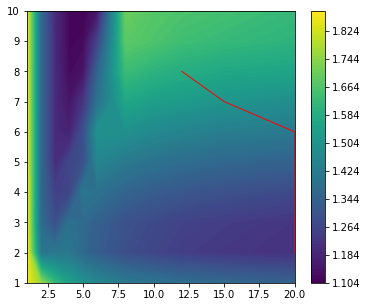

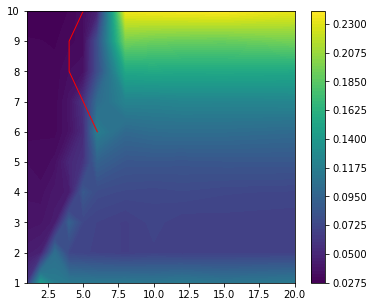

In [34]:
def neighbours(x, y, xmin, xmax, ymin, ymax):
    return [(x + 1, y - 1) if x < xmax and 0 < y else None,
            (x + 1, y) if x < xmax else None,
            (x + 1, y + 1) if x < xmax and y < ymax else None,
            (x, y + 1) if y < ymax else None,
            (x - 1, y + 1) if 0 < x and y < ymax else None,
            (x - 1, y) if 0 < x else None,
            (x - 1, y - 1) if 0 < x and 0 < y else None,
            (x, y - 1) if 0 < y else None]


def Greedy_Hill_Climbing(f , df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    fmin = f(Trains_PH_sort[x0], Sig_blocks_sort[y0])

    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in neighbours(xi, yi, xmin, xmax, ymin, ymax):
            if xy != None:
                x, y = xy
                ff = Return_JT(Trains_PH_sort[x], Sig_blocks_sort[y])
                if ff < fi:
                    xi = x
                    yi = y
                    fi = ff
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='red', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Greedy_Hill_Climbing(Return_JT, Journey_Time, 'AVG_Journey_Time')
Greedy_Hill_Climbing(Return_JT, Journey_Time, 'STD_Journey_Time')

### 4.2.2 Randomized Hill Climbing
In this case a neighbour is chosen at random and if there is an improvement, the algorithm moves to the new point

 x y  f(x, y)
 3 3    1.261
 2 4    1.204
 2 5    1.197
 2 6    1.197
 3 5    1.175
 3 6    1.146
 4 7    1.141
 3 8    1.117
 3 9    1.116
 4 9    1.112
 x y  f(x, y)
 9 2    1.242
10 1    1.215


(2, 20, 2, 1.2146325193441925)

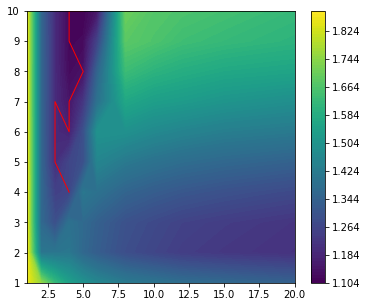

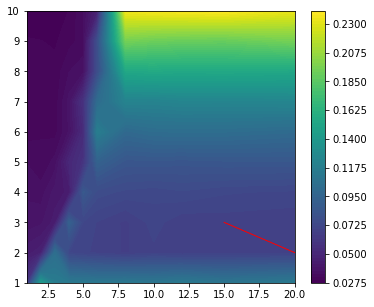

In [35]:
def neighbours_Random(x, y, xmin, xmax, ymin, ymax):
    return ([(x + 1, y - 1)] if x < xmax and 0 < y else []
            ) + ([(x + 1, y)] if x < xmax else []
                 ) + ([(x + 1, y + 1)] if (x < xmax and y < ymax) else []
                      ) + ([(x, y + 1)] if (y < ymax) else []
                           ) + ([(x - 1, y + 1)] if (0 < x and y < ymax) else []
                                ) + ([(x - 1, y)] if (0 < x) else []
                                     ) + ([(x - 1, y - 1)] if (0 < x and 0 < y) else []
                                          ) + ([(x, y - 1)] if (0 < y) else [])


def Randomized_Hill_Climbing(f , df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    fmin = f(Trains_PH_sort[x0], Sig_blocks_sort[y0])

    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in np.random.permutation(neighbours_Random(xi, yi, xmin, xmax, ymin, ymax)):
            x, y = xy
            ff = f(Trains_PH_sort[x], Sig_blocks_sort[y])
            if ff < fi:
                xi = x
                yi = y
                fi = ff
                break
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='red', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Randomized_Hill_Climbing(Return_JT , Journey_Time, 'AVG_Journey_Time')
Randomized_Hill_Climbing(Return_JT , Journey_Time, 'STD_Journey_Time')

### 4.2.3 Monte Carlo Optimization
In this case, a number of points are chosen at random. A random point is then chosen, whenever a new point with a lower objective function is found, then it is kept as the next best candidate.

(3, 4, 15, 1.1156139335982582)

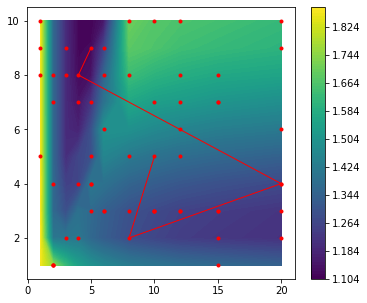

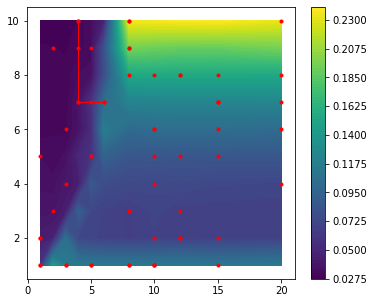

In [38]:
def Monte_Carlo(n, f, df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x = [random.choice(Trains_PH_idx) for i in range(n)]
    y = [random.choice(Sig_blocks_idx) for i in range(n)]
    xp = [x[0]]
    yp = [y[0]]
    fmin = f(Trains_PH_sort[xp[0]], Sig_blocks_sort[yp[0]])

    for i in range(1, len(x)):
        fi = f(Trains_PH_sort[x[i]], Sig_blocks_sort[y[i]])
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
            
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.scatter([Trains_PH_sort[i] for i in x], [Sig_blocks_sort[i] for i in y], c='red', marker='.')

    plt.plot([Trains_PH_sort[i] for i in xp], [Sig_blocks_sort[i] for i in yp], c='red', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Monte_Carlo(60, Return_JT, Journey_Time, 'AVG_Journey_Time')
Monte_Carlo(60, Return_JT, Journey_Time, 'STD_Journey_Time')

## 4.3 Results
Clearly the optimal solution to minimize journey time is to realease 5 trains per hour and use 10 signalling blocks. This is intuitive as the wait time for passengers is reasonable given the frequency of trains. The low frequency of trains means that disruption is infrequent along the stretch between London and Birmingham.

Although this optimizes the journey time, it is below the economic requirement of 9 trains per hour. Assuming this as a constraint, the best option would be to use 20 Trains per hour and use two signalling blocks. The large frequency of trains means that wait times are very low and the small number of signalling blocks means that trains spend a lot of time at top speed.

# 5. Maximize the Throughput of Passengers
## 5.1 The Simulation
Here a decision has to be made on whether to use the longer trains or the shorter trains. The longer trains can carry more people but they take longer to load which means longer waiting times at stops. Given the information in description, the waiting times are modelled as follows:

In [40]:
class passenger_wait_time:
    def __init__(self,Train_Size):
        self.Train_Size=Train_Size

    def London_Euston(self):
        self.wt = (random.uniform(1, 1.2) * self.Train_Size) / (60 * 60)
        return (self.wt)

    def London_OOC(self):
        Arrival_Time = (random.uniform(1, 1.2) * self.Train_Size) / (60 * 60)
        self.wt=Arrival_Time
        return (self.wt)

    def Birmingham_Int(self):
        Disembark_Time = (random.uniform(1, 1.2) * self.Train_Size) / (60 * 60)
        self.wt = Disembark_Time
        return (self.wt)

    def Birmingham_Curzon(self):
        Disembark_Time = (random.uniform(1, 1.2) * self.Train_Size) / (60 * 60)
        self.wt = Disembark_Time
        return (self.wt)

The simulation class must be edited to collect the new information. The following is added:
1. Train Capacity parameter. This is the amount of passengers that are serviced by each train.
2. Passenger Arrival Rate. This is average rate at which passengers arrive in each hour. This is modelled as a poisson random variable. The number of arrivals between each train is a random poisson value divided by the number of trains per hour.
3. New statistcs are collected at each iteration. These are as follows:
    - Arrival of passengers
    - The passengers processed by the respective train
    - The backlog of passengers
    
The simulation node is as follows:

In [41]:
class London_2_Birmingham_Passenger(object):
    def __init__(self, env, k, Times, Day_Num, wait_class, Train_Capacity, arrival_Rate):
        self.Train_Capacity = Train_Capacity
        self.env = env
        self.k = k
        self.Times = Times
        self.action = env.process(self.run(self.k, self.Times))
        self.Day_Num = Day_Num
        self.wait_class = wait_class
        self.arrival_Rate = arrival_Rate
        self.df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             })

        self.arr_df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Day': [],'Passengers_Arrived':[]
            , 'Passengers_Processed':[], 'Back_Log': []
             })


    # The overall process
    def run(self, k, Times):
        sig_blocks = Block_Location(k)

        # create resources
        avail = {}
        avail['Straight'] = self.Resources(k)  # A vector of train locations, True indcates presence of train
        avail['London'] = simpy.Resource(self.env, capacity=1)
        avail['Birmingham'] = self.Resources(2)

        Train_obj = Train(self.env, sig_blocks, avail, self.wait_class)

        global df_out
        df_out = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [],
             'Trains_PH': []})

        #Assume passengers arrive at random intervals

        x = 1  # Train ID
        arrived_passengers = np.random.poisson(self.arrival_Rate / Times)

        #create row dict to append to data frame
        row = {}

        row['Passengers_Arrived'] = arrived_passengers
        row['Train_No'] = x
        #row['Trains_PH'] = Times
        row['No_Blocks'] = k

        served_passengers = min(self.Train_Capacity,arrived_passengers)

        backlog = arrived_passengers - served_passengers

        self.env.process(Train_obj.Execute_Train(x))
        #Put them into data frame
        row['Passengers_Processed'] = served_passengers
        row['Back_Log'] = backlog
        self.arr_df = self.arr_df.append(row , ignore_index=True)

        while True:
            yield (self.env.timeout(1 / Times))  # Times per hour
            arrived_passengers = np.random.poisson(self.arrival_Rate/Times)

            x = x + 1
            row={}
            row['Passengers_Arrived'] = arrived_passengers
            row['Train_No'] = x
            #row['Trains_PH'] = Times
            row['No_Blocks'] = k

            served_passengers = min(self.Train_Capacity, arrived_passengers)
            backlog = arrived_passengers - served_passengers + backlog

            self.env.process(Train_obj.Execute_Train(x))

            row['Passengers_Processed'] = served_passengers
            row['Back_Log'] = backlog
            self.arr_df = self.arr_df.append(row, ignore_index=True)


    def Resources(self, k):
        out_l = []
        for i in range(k):
            out_l.append(simpy.Resource(self.env, capacity=1))
        return (out_l)

    def Return_Df(self):
        #join to create the final dataset
        self.df=df_out
        out_df = pd.merge(self.df ,self.arr_df, on = ['Train_No','No_Blocks'], how = 'left')
        out_df['arrivals_PH'] = self.arrival_Rate
        out_df['Journey_Time'] = out_df['Arrival_Time'] - out_df['Departure_Time']
        out_df['Day'] = self.Day_Num
        out_df['Trains_PH'] = self.Times
        return (out_df)


## 5.2 The Additional Simulation Parameters:
The new parameters are as follows:
1. Train capacity for both small and large trains
2. The new passenger weight classes
3. A vector of arrival rates, given the computational cost of this simulation, the arrival rates will be iterated in frequecys of 1000. The estimated max capacity of the whole system with the information given is 10,000 people per hour.

In [42]:
train_capacity = [294,441]
pass_wt = [passenger_wait_time(200) , passenger_wait_time(300)]

Arrival_Rates = np.arange(1,6)*1000 #between 1000 and 10000 passengers per hour in intervals of 2000

Train_sze_Dict = {'Small':[train_capacity[0],pass_wt[0]]
                  ,'Large':[train_capacity[1],pass_wt[1]]}

## 5.3 The Simulation
The simulation is largely the same as before but there is extra iteration done to accomadate for varying train sizes and arrival rates:

In [43]:
def Full_Simulation_Passenger(n_days):  # No Variable Inputs, keep everything consistent

    Output_df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': [],'arrivals_PH':[],'Passengers_Processed':[],'Back_Log':[],'Train_Size':[]})

    for Tr in Trains_PH:
        for sig in Sig_blocks:
            for day in range(1, n_days+1):  # 100 days
                for rate in Arrival_Rates:
                    for Train_Size in ['Small','Large']:
                        print(Tr, sig, day, rate, Train_Size)
                        env = simpy.Environment()
                        proc = London_2_Birmingham_Passenger(env, sig, Tr, 1, Train_sze_Dict[Train_Size][1],Train_sze_Dict[Train_Size][0],rate)
                        env.run(until=4)  # Assume 4 peak hours
                        pre_out = proc.Return_Df()
                        pre_out['Train_Size'] = Train_Size
                        Output_df = Output_df.append(pre_out, ignore_index=True)

    return (Output_df)

Sim_Data_Passengers = Full_Simulation_Passenger(1)

1 1 1 1000 Small
1 1 1 1000 Large
1 1 1 2000 Small
1 1 1 2000 Large
1 1 1 3000 Small
1 1 1 3000 Large


C:\Users\i_am_yohan\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1 1 1 4000 Small
1 1 1 4000 Large
1 1 1 5000 Small
1 1 1 5000 Large
1 2 1 1000 Small
1 2 1 1000 Large
1 2 1 2000 Small
1 2 1 2000 Large
1 2 1 3000 Small
1 2 1 3000 Large
1 2 1 4000 Small
1 2 1 4000 Large
1 2 1 5000 Small
1 2 1 5000 Large
1 3 1 1000 Small
1 3 1 1000 Large
1 3 1 2000 Small
1 3 1 2000 Large
1 3 1 3000 Small
1 3 1 3000 Large
1 3 1 4000 Small
1 3 1 4000 Large
1 3 1 5000 Small
1 3 1 5000 Large
1 4 1 1000 Small
1 4 1 1000 Large
1 4 1 2000 Small
1 4 1 2000 Large
1 4 1 3000 Small
1 4 1 3000 Large
1 4 1 4000 Small
1 4 1 4000 Large
1 4 1 5000 Small
1 4 1 5000 Large
1 5 1 1000 Small
1 5 1 1000 Large
1 5 1 2000 Small
1 5 1 2000 Large
1 5 1 3000 Small
1 5 1 3000 Large
1 5 1 4000 Small
1 5 1 4000 Large
1 5 1 5000 Small
1 5 1 5000 Large
1 6 1 1000 Small
1 6 1 1000 Large
1 6 1 2000 Small
1 6 1 2000 Large
1 6 1 3000 Small
1 6 1 3000 Large
1 6 1 4000 Small
1 6 1 4000 Large
1 6 1 5000 Small
1 6 1 5000 Large
1 7 1 1000 Small
1 7 1 1000 Large
1 7 1 2000 Small
1 7 1 2000 Large
1 7 1 3000 Sma

5 9 1 4000 Large
5 9 1 5000 Small
5 9 1 5000 Large
5 10 1 1000 Small
5 10 1 1000 Large
5 10 1 2000 Small
5 10 1 2000 Large
5 10 1 3000 Small
5 10 1 3000 Large
5 10 1 4000 Small
5 10 1 4000 Large
5 10 1 5000 Small
5 10 1 5000 Large
6 1 1 1000 Small
6 1 1 1000 Large
6 1 1 2000 Small
6 1 1 2000 Large
6 1 1 3000 Small
6 1 1 3000 Large
6 1 1 4000 Small
6 1 1 4000 Large
6 1 1 5000 Small
6 1 1 5000 Large
6 2 1 1000 Small
6 2 1 1000 Large
6 2 1 2000 Small
6 2 1 2000 Large
6 2 1 3000 Small
6 2 1 3000 Large
6 2 1 4000 Small
6 2 1 4000 Large
6 2 1 5000 Small
6 2 1 5000 Large
6 3 1 1000 Small
6 3 1 1000 Large
6 3 1 2000 Small
6 3 1 2000 Large
6 3 1 3000 Small
6 3 1 3000 Large
6 3 1 4000 Small
6 3 1 4000 Large
6 3 1 5000 Small
6 3 1 5000 Large
6 4 1 1000 Small
6 4 1 1000 Large
6 4 1 2000 Small
6 4 1 2000 Large
6 4 1 3000 Small
6 4 1 3000 Large
6 4 1 4000 Small
6 4 1 4000 Large
6 4 1 5000 Small
6 4 1 5000 Large
6 5 1 1000 Small
6 5 1 1000 Large
6 5 1 2000 Small
6 5 1 2000 Large
6 5 1 3000 Small
6 5 

15 6 1 2000 Large
15 6 1 3000 Small
15 6 1 3000 Large
15 6 1 4000 Small
15 6 1 4000 Large
15 6 1 5000 Small
15 6 1 5000 Large
15 7 1 1000 Small
15 7 1 1000 Large
15 7 1 2000 Small
15 7 1 2000 Large
15 7 1 3000 Small
15 7 1 3000 Large
15 7 1 4000 Small
15 7 1 4000 Large
15 7 1 5000 Small
15 7 1 5000 Large
15 8 1 1000 Small
15 8 1 1000 Large
15 8 1 2000 Small
15 8 1 2000 Large
15 8 1 3000 Small
15 8 1 3000 Large
15 8 1 4000 Small
15 8 1 4000 Large
15 8 1 5000 Small
15 8 1 5000 Large
15 9 1 1000 Small
15 9 1 1000 Large
15 9 1 2000 Small
15 9 1 2000 Large
15 9 1 3000 Small
15 9 1 3000 Large
15 9 1 4000 Small
15 9 1 4000 Large
15 9 1 5000 Small
15 9 1 5000 Large
15 10 1 1000 Small
15 10 1 1000 Large
15 10 1 2000 Small
15 10 1 2000 Large
15 10 1 3000 Small
15 10 1 3000 Large
15 10 1 4000 Small
15 10 1 4000 Large
15 10 1 5000 Small
15 10 1 5000 Large
20 1 1 1000 Small
20 1 1 1000 Large
20 1 1 2000 Small
20 1 1 2000 Large
20 1 1 3000 Small
20 1 1 3000 Large
20 1 1 4000 Small
20 1 1 4000 Large


# 6. The Simulation Results
To assess the throughput of passengers, the ratio of arrivals to passengers processed will be assessed. A low value for this indicates that a large number of passengers can be processed.
The results of the simulation will be assessed as follows:

In [44]:
Sim_Data_Passengers['Service_Rate'] = Sim_Data_Passengers['Passengers_Arrived']/Sim_Data_Passengers['Passengers_Processed']

Service_Rate = Sim_Data_Passengers.groupby(['Trains_PH', 'No_Blocks','Train_Size']).agg(
        AVG_Service_Rate=pd.NamedAgg(column = 'Service_Rate', aggfunc='mean'),
        STD_Service_Rate=pd.NamedAgg(column = 'Service_Rate', aggfunc='std'),
        MED_Service_Rate=pd.NamedAgg(column = 'Service_Rate', aggfunc='median'))

Service_Rate = Service_Rate.reset_index(level=['Trains_PH', 'No_Blocks','Train_Size'])

Service_Rate_Small = Service_Rate[Service_Rate['Train_Size'] == 'Small'].drop(['Train_Size'],axis=1)
Service_Rate_Large = Service_Rate[Service_Rate['Train_Size'] == 'Large'].drop(['Train_Size'],axis=1)

#All monotonic
plot_3D(Service_Rate_Small,'AVG_Service_Rate')
plot_3D(Service_Rate_Large,'AVG_Service_Rate')

plot_3D(Service_Rate_Small,'STD_Service_Rate')
plot_3D(Service_Rate_Large,'STD_Service_Rate')

plot_3D(Service_Rate_Small,'MED_Service_Rate')
plot_3D(Service_Rate_Large,'MED_Service_Rate')

It is clear that the larger the number of trains per hour, the more passengers that can be processed. This is intuitive. Given that the throughput of passengers does not vary with the number of signalling blocks, it is safe to assume that two signalling blocks would be optimal

# 7. Choosing the Right Train Size
The goal here is to both maximize the throughput of passengers and minimize the journey time. To do this, a new feature will be created. The feature will be a multiplicative combination of both normalized journey time and Service rate. This will be optmized using the Monte-Carlo method. The Monte-Carlo method was chosen because it performed the best overall.

(3, 20, 2, 0.0)

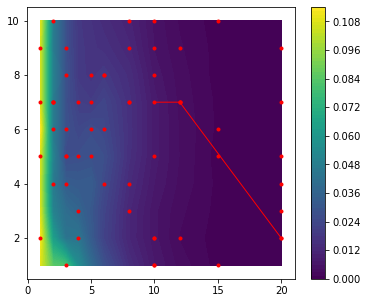

In [48]:
Sim_Data_Passengers['Service_Rate_Norm'] = (Sim_Data_Passengers['Service_Rate'] - Sim_Data_Passengers['Service_Rate'].min())/(Sim_Data_Passengers['Service_Rate'].max() - Sim_Data_Passengers['Service_Rate'].min())
Sim_Data_Passengers['Journey_Time_Norm'] = (Sim_Data_Passengers['Journey_Time'] - Sim_Data_Passengers['Journey_Time'].min())/(Sim_Data_Passengers['Journey_Time'].max() - Sim_Data_Passengers['Journey_Time'].min())

Sim_Data_Passengers['Service_Rate_and_Journey_Time'] = Sim_Data_Passengers['Service_Rate_Norm']*Sim_Data_Passengers['Journey_Time_Norm']

Service_Rate_JT = Sim_Data_Passengers.groupby(['Trains_PH', 'No_Blocks','Train_Size']).agg(
        AVG_Service_Rate_JT=pd.NamedAgg(column = 'Service_Rate_and_Journey_Time', aggfunc='mean'))

Service_Rate_JT = Service_Rate_JT.reset_index(level=['Trains_PH', 'No_Blocks','Train_Size'])

Service_Rate_JT_Small = Service_Rate_JT[Service_Rate_JT['Train_Size'] == 'Small'].drop(['Train_Size'],axis=1)
Service_Rate_JT_Large = Service_Rate_JT[Service_Rate_JT['Train_Size'] == 'Large'].drop(['Train_Size'],axis=1)
    
def SR_JT_Small(n_Trains_PH, n_Sig_blocks):
    return (float(Service_Rate_JT_Small['AVG_Service_Rate_JT'][Service_Rate_JT_Small['Trains_PH'] == n_Trains_PH][
                      Service_Rate_JT_Small['No_Blocks'] == n_Sig_blocks]))

def SR_JT_Large(n_Trains_PH, n_Sig_blocks):
    return (float(Service_Rate_JT_Large['AVG_Service_Rate_JT'][Service_Rate_JT_Large['Trains_PH'] == n_Trains_PH][
                      Service_Rate_JT_Large['No_Blocks'] == n_Sig_blocks]))

SR_JT_Small(2, 2)

Monte_Carlo(60, SR_JT_Small , Service_Rate_JT_Small, 'AVG_Service_Rate_JT')


(4, 15, 5, 0.0)

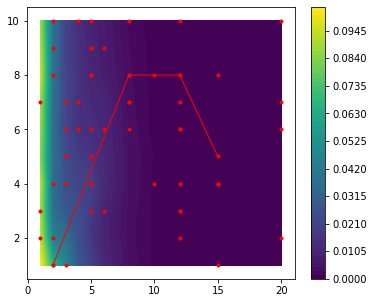

In [49]:
Monte_Carlo(60, SR_JT_Large, Service_Rate_JT_Large, 'AVG_Service_Rate_JT')

Given this information, it is quite clear that the larger train will both minimize journey time and maximize the throughput of passengers.